# CS 4120 - Song Genre Classification

We are compare the performance of Random Forest, K-Nearest Neighbors, Multinomial Naive Bayes, Complement Naive Bayes models, and a Neural Network with LSTM cell for the task of classifying songs by genre.

## Dataset

We use a [Kaggle dataset](https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres?resource=download&select=lyrics-data.csv) with data on many artists and songs originally scraped from Vagalume.com.
Since the dataset associates artists with songs and their lyrics, then genres with artists separately, we join the two datasets in order to make associations between genres and lyrics in order to obtain data to train our models.

## Getting Started

From the Kaggle dataset (linked above), download `artists-data.csv` to `data/artists-data.csv` and `lyrics-data.csv` to `data/lyrics-data.csv`.
Install all the packages imported in the following cell.

In [44]:
%%capture
import pandas as pd
import nltk
import numpy as np
import string
import seaborn as sns
import gensim
from gensim import models

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

from statistics import mean

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('words', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Data Preprocessing

In [2]:
# suppress some warnings in cell output
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Import Song Data

song_data = pd.read_csv('./data/lyrics-data.csv')
english_songs = song_data.loc[song_data['language'] == 'en']
english_songs.rename(columns={'ALink':'Link'}, inplace=True)
english_songs.head()

,Link,SName,SLink,Lyric,language
69,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en
86,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en
88,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en
111,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en
140,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en


In [4]:
# Import Artist Data

artist_data = pd.read_csv('./data/artists-data.csv')
artist_data = artist_data.drop_duplicates(subset='Link', keep='first')
artist_data.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [5]:
# Merge Dataframes

combined_data = pd.merge(english_songs, artist_data, on='Link')
combined_data = combined_data[["SName", "Artist", "Lyric", "Genres"]]
combined_data = combined_data[combined_data.Lyric.notnull()]
combined_data = combined_data[combined_data.Genres.notnull()]
combined_data

,SName,Artist,Lyric,Genres
0,Careless Whisper,Ivete Sangalo,I feel so unsure\nAs I take your hand and lead...,Pop; Axé; Romântico
1,Could You Be Loved / Citação Musical do Rap: S...,Ivete Sangalo,"Don't let them fool, ya\nOr even try to school...",Pop; Axé; Romântico
2,Cruisin' (Part. Saulo),Ivete Sangalo,"Baby, let's cruise, away from here\nDon't be c...",Pop; Axé; Romântico
3,Easy,Ivete Sangalo,"Know it sounds funny\nBut, I just can't stand ...",Pop; Axé; Romântico
4,For Your Babies (The Voice cover),Ivete Sangalo,You've got that look again\nThe one I hoped I ...,Pop; Axé; Romântico
...,...,...,...,...
191382,The Waiting,Johnny Clegg,Chorus\nHere we stand waiting on the plain\nDa...,World Music; Gospel/Religioso
191383,Too Early For The Sky,Johnny Clegg,I nearly disappeared into the mouth of a croco...,World Music; Gospel/Religioso
191384,Warsaw 1943 (I Never Betrayed The Revolution),Johnny Clegg,"Amambuka, amambuka azothengisa izwe lakithi, i...",World Music; Gospel/Religioso
191385,When The System Has Fallen,Johnny Clegg,Sweat in the heat for days on end\nwaiting for...,World Music; Gospel/Religioso


In [ ]:
artists = combined_data.Artist.unique()
genres = combined_data.Genres.unique()
labels = ["Blues", "Country", "Hip Hop", "Jazz", "Pop", "Rock"]

In [ ]:
# Randomely select 1000 songs from each genre
SONG_PER_GENRE = 1000

rows = []

for label in labels:
    genre_data = combined_data[combined_data.Genres == label]
    sampled_genre_data = []
    count = 0
    for _, row in genre_data.sample(frac=1).iterrows():
        if len(row.Lyric.strip()) == 0:
            continue
        sampled_genre_data.append(row)
        count += 1
        if count == SONG_PER_GENRE:
            break
    else:
        raise ValueError(f'Not enough songs of genre {label}')
    sampled_genre_data = pd.DataFrame(sampled_genre_data)
    sampled_genre_data.Genres = label
    rows.append(sampled_genre_data)

combined_genre_data = pd.concat(rows).reset_index().drop("index", axis=1)
combined_genre_data

In [ ]:
combined_genre_data.to_csv("combined_genre_data.csv")

## Reload the data

In [24]:
combined_genre_data = pd.read_csv("combined_genre_data.csv")
combined_genre_data.drop('Unnamed: 0', axis=1, inplace=True)
combined_genre_data.sample(5)

,SName,Artist,Lyric,Genres
1441,I Can't Love You Anymore,Lyle Lovett,This Georgia road is red\nThe Georgia sky is b...,Country
987,I Walk Alone,Gary Clark Jr.,I walk alone because I'll always say I'm sorry...,Blues
2652,It's A Man's Game,E-40,[E-40]\nOoooh (ooooh) pencil me in (pencil me ...,Hip Hop
4926,Skyscraper,Fifth Harmony,"Skies are crying, I am watching\nCatching tear...",Pop
3753,Isn't This A Lovely Day?,Louis Armstrong,The weather is fright'ning\nThe thunder and li...,Jazz


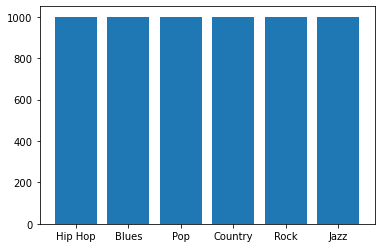

In [13]:
labels_set = set(combined_genre_data.Genres)
labels_count = []
for label in labels_set:
    labels_count.append(list(combined_genre_data.Genres).count(label))
plt.bar(list(labels_set), labels_count)
plt.show()

In [25]:
def train_and_pipeline(lyrics):
    
    # Split the data 75% training and 25% testing
    X_train, X_test, y_train, y_test = train_test_split(lyrics, combined_genre_data.Genres, test_size=0.25) 
    
    pipe_MNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', MultinomialNB())
                       ])
    
    pipe_CNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', ComplementNB())
                       ])

    pipe_RF = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', RandomForestClassifier())
                       ])

    pipe_KNN = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', KNeighborsClassifier())
                       ])

    pipelines = [pipe_MNB, pipe_CNB, pipe_RF, pipe_KNN]
    pipeline_names = ['Multinomail NB', 'Complement NB', 'Random Forest', "KNN"]

    for pipe in pipelines:
        print(pipe)
        pipe.fit(X_train, y_train)

    lemmed_basic_scores = []
    for index, val in enumerate(pipelines):
        tup = (pipeline_names[index], val.score(X_test, y_test))
        lemmed_basic_scores.append(tup)
        print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))
        
    return lemmed_basic_scores

In [26]:
results = Counter()
lyrics_list = list(combined_genre_data.Lyric)
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
english = list(set(nltk.corpus.words.words()))
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")

# Lemmatization

In [27]:
def clean_lyrics_lemma(lyrics_list):
    cleaned = []
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_lemmas)
        cleaned.append(c)
    return cleaned

In [28]:
lemmed_lyrics = clean_lyrics_lemma(lyrics_list)
len(lemmed_lyrics)

6000

In [63]:
lyrics_lengths = [len(lyrics.split()) for lyrics in lemmed_lyrics]

Text(0.5, 0, 'Number of Lyrics')

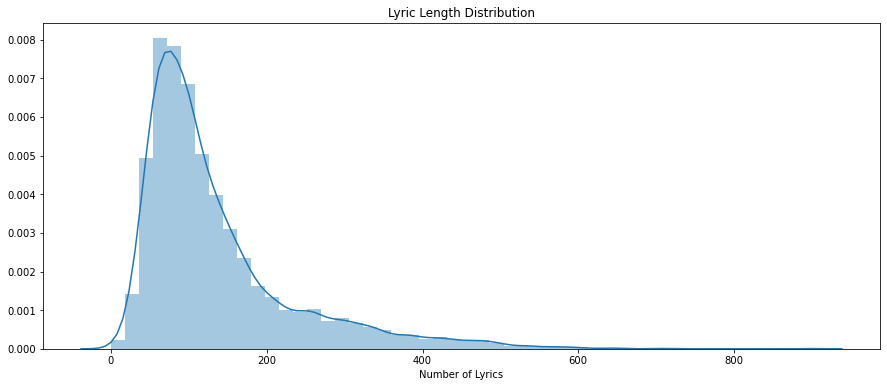

In [64]:
sns.distplot(lyrics_lengths)
plt.gcf().set_size_inches(15, 6)
plt.title("Lyric Length Distribution")
plt.xlabel("Number of Lyrics")

In [47]:
genre_lyrics_length  = []
genre_unique_words = []
for label in labels_set:
    label_index_list = [i for i in range(len(list(combined_genre_data.Genres))) if  list(combined_genre_data.Genres)[i] == label]
    lyrics_len = []
    lyrics_set = set()
    for index in label_index_list:
        split_lyrics = lemmed_lyrics[index].split()
        lyrics_len.append(len(split_lyrics))
        for word in split_lyrics:
            lyrics_set.add(word)
    genre_lyrics_length.append(mean(lyrics_len))
    genre_unique_words.append(len(lyrics_set))
        

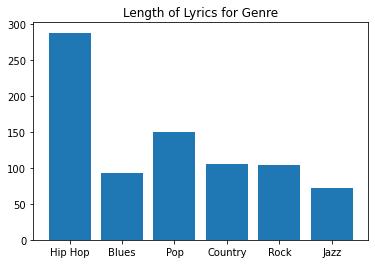

In [50]:
plt.bar(list(labels_set), genre_lyrics_length)
plt.title('Length of Lyrics for Genre')
plt.show()

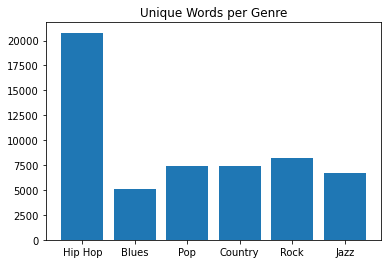

In [51]:
plt.bar(list(labels_set), genre_unique_words)
plt.title('Unique Words per Genre')
plt.show()

In [31]:
results["lemmed"] = train_and_pipeline(lemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.585
Complement NB pipeline test accuracy: 0.589
Random Forest pipeline test accuracy: 0.583
KNN pipeline test accuracy: 0.377


# Stemming

In [32]:
def clean_lyrics_stemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_stemmas = [stemmer.stem(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_stemmas)
        cleaned.append(c)
    return cleaned

In [33]:
stemmed_lyrics = clean_lyrics_stemma(lyrics_list)

In [34]:
results["stemmed"] = train_and_pipeline(stemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.571
Complement NB pipeline test accuracy: 0.585
Random Forest pipeline test accuracy: 0.577
KNN pipeline test accuracy: 0.388


# Stemmed & Lemmatized

In [35]:
lemmatized_stemmed_lyrics = clean_lyrics_lemma(stemmed_lyrics)

In [36]:
results["lemmatized_stemmed"] = train_and_pipeline(lemmatized_stemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.585
Complement NB pipeline test accuracy: 0.591
Random Forest pipeline test accuracy: 0.569
KNN pipeline test accuracy: 0.364


In [37]:
stemmed_lemmatized_lyrics = clean_lyrics_lemma(lemmed_lyrics)

In [38]:
results["stemmed_lemmatized"] = train_and_pipeline(stemmed_lemmatized_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.575
Complement NB pipeline test accuracy: 0.597
Random Forest pipeline test accuracy: 0.566
KNN pipeline test accuracy: 0.362


In [39]:
results

Counter({'lemmed': [('Multinomail NB', 0.5853333333333334),
          ('Complement NB', 0.5893333333333334),
          ('Random Forest', 0.5833333333333334),
          ('KNN', 0.37666666666666665)],
         'stemmed': [('Multinomail NB', 0.5706666666666667),
          ('Complement NB', 0.5853333333333334),
          ('Random Forest', 0.5766666666666667),
          ('KNN', 0.388)],
         'lemmatized_stemmed': [('Multinomail NB', 0.5846666666666667),
          ('Complement NB', 0.5906666666666667),
          ('Random Forest', 0.5693333333333334),
          ('KNN', 0.364)],
         'stemmed_lemmatized': [('Multinomail NB', 0.5746666666666667),
          ('Complement NB', 0.5973333333333334),
          ('Random Forest', 0.566),
          ('KNN', 0.362)]})

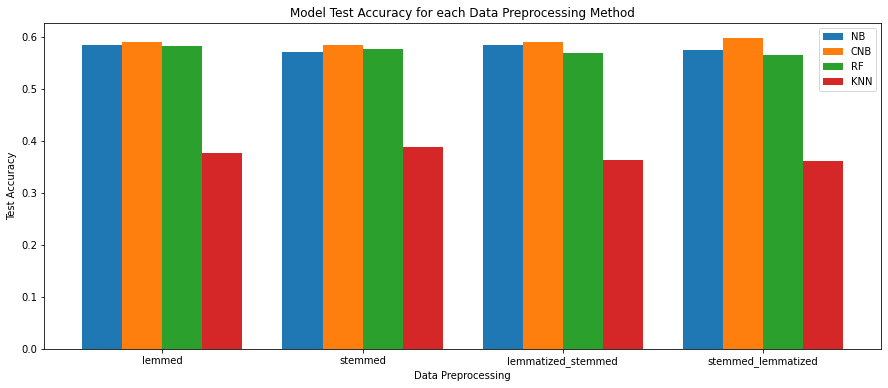

In [40]:
X = results.keys()

MNB = [results[x][0][1] for x in X]
CNB = [results[x][1][1] for x in X]
RF = [results[x][2][1] for x in X]
KNN = [results[x][3][1] for x in X]

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.3, MNB, 0.2, label = 'NB')
plt.bar(X_axis - 0.1, CNB, 0.2, label = 'CNB')
plt.bar(X_axis + 0.1, RF, 0.2, label = 'RF')
plt.bar(X_axis + 0.3, KNN, 0.2, label = 'KNN')

plt.xticks(X_axis, X)

plt.gcf().set_size_inches(15, 6)
plt.xlabel("Data Preprocessing")
plt.ylabel('Test Accuracy')
plt.title("Model Test Accuracy for each Data Preprocessing Method")
plt.legend()
plt.show()

In [20]:
# Based on the results -> 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(lemmed_lyrics, combined_genre_data.Genres, test_size=0.25) 

In [74]:
le = LabelEncoder()
le.fit(combined_genre_data.Genres.values)

LabelEncoder()

# Metrics

In [77]:
def score_report(classes, classified_train, gold_train, classified_test, gold_test):
    print("----------- Training Set Report -----------")
    print("Accuracy", accuracy_score(gold_train, classified_train))
    print("Precision", precision_multi(gold_train, classified_train))
    print("Recall", recall_multi(gold_train, classified_train))
    print("F1", f1_multi(gold_train, classified_train))
    cm = confusion_matrix(gold_train, classified_train, labels=classes)
    print("Confusion matrix", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()
    print("----------- Testing Set Report -----------")
    print("Accuracy", accuracy_score(gold_test, classified_test))
    print("Precision", precision_multi(gold_test, classified_test))
    print("Recall", recall_multi(gold_test, classified_test))
    print("F1", f1_multi(gold_test, classified_test))
    cm = confusion_matrix(gold_test, classified_test, labels=classes)
    print("Confusion matrix", cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

In [78]:
from collections import Counter
from statistics import mean
def precision_multi_dict(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    classes = set(gold_labels)
    class_precisions = Counter()
    for _class in classes:
        den = 0
        num = 0
        for i in range(len(classified_labels)):
            if classified_labels[i] == _class:
                den += 1
                if gold_labels[i] == _class:
                    num += 1
        if den == 0:
            class_precisions[_class] = 0.0
        else:
            class_precisions[_class] = float(num / den)
    return class_precisions

def precision_multi(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    precision_dict = precision_multi_dict(gold_labels, classified_labels)
    return float(mean(precision_dict.values()))

def recall_multi_dict(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    classes = set(gold_labels)
    class_recalls = Counter()
    for _class in classes:
        den = 0
        num = 0
        for i in range(len(gold_labels)):
            if gold_labels[i] == _class:
                den += 1
                if classified_labels[i] == _class:
                    num += 1
        if den == 0:
            class_precisions[_class] = 0.0
        else:
            class_recalls[_class] = float(num / den)
    return class_recalls

def recall_multi(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    recall_dict = recall_multi_dict(gold_labels, classified_labels)
    return float(mean(recall_dict.values()))

def f1_multi(gold_labels, classified_labels):
    # gold labels is a list of strings of the true labels
    # classified labels is a list of strings of the labels assigned by the classifier
    precision_dict = precision_multi_dict(gold_labels, classified_labels)
    recall_dict = recall_multi_dict(gold_labels, classified_labels)

    classes = precision_dict.keys()

    f1_scores = []
    for _class in classes:
        class_precision = precision_dict[_class]
        class_recall = recall_dict[_class]
        if class_precision + class_recall == 0:
            f1_scores.append(0.0)
        else:
            f1_scores.append(float((2 * class_precision * class_recall) / (class_precision + class_recall)))

    return mean(f1_scores)


# Random Forest Classifier

In [22]:
rfc = RandomForestClassifier()

In [23]:
GS_pipe_RF = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', RandomForestClassifier())
                       ])

rf_param_grid = dict(clf__n_estimators = [10, 30, 100, 200],
                  clf__criterion = ['gini', 'entropy'],
                  clf__max_depth = [2, 6, 10, 15], 
                  clf__min_samples_split = [5, 10],
                  clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3)

gs_RF.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [2, 6, 10, 15],
                         'clf__min_samples_leaf': [3, 6],
                         'clf__min_samples_split': [5, 10],
                         'clf__n_estimators': [10, 30, 100, 200]},
             scoring='accuracy')

In [24]:
rf_gs_testing_score = gs_RF.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(rf_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_RF.best_params_))

Mean Testing Score: 57.87%
Best Parameter Combination Found During Grid Search: 
{'clf__criterion': 'gini', 'clf__max_depth': 15, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}


----------- Training Set Report -----------
Accuracy 0.7933333333333333
Precision 0.7930759950600708
Recall 0.8143048471659574
F1 0.7945448263582524
Confusion matrix [[617  40   9  38  23  65]
 [ 14 519   3   3  19  13]
 [  7   8 699   2  43   3]
 [ 72 146  17 679  75 115]
 [ 15  22  18   6 512  21]
 [ 25  21  11  20  56 544]]


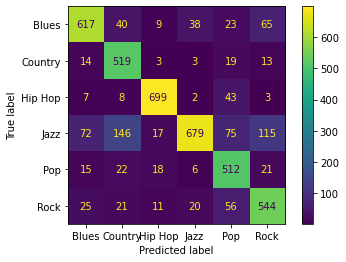

----------- Testing Set Report -----------
Accuracy 0.5786666666666667
Precision 0.57848286831263
Recall 0.5842955403384554
F1 0.564525526449072
Confusion matrix [[164  35   5  17  17  30]
 [ 12  69   1   5  11  21]
 [  3   7 203   2  30   6]
 [ 34  65  12 210  43  60]
 [ 12  35  16   4 129  29]
 [ 25  33   6  14  42  93]]


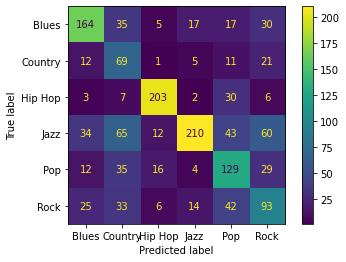

In [53]:
rf_classified_train = gs_RF.predict(X_train)
rf_classified_test = gs_RF.predict(X_test)
score_report(le.classes_, np.array(y_train), rf_classified_train, np.array(y_test), rf_classified_test)

# Multinomial Naive Bayes

In [25]:
GS_pipe_MNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', MultinomialNB())
                       ])

sorted(GS_pipe_MNB.get_params().keys())

mnb_param_grid = dict(clf__alpha = [.01, .05, .1, .2, .4, 1])

gs_MNB = GridSearchCV(estimator=GS_pipe_MNB,
            param_grid=mnb_param_grid,
            scoring='accuracy',
            cv=3)

gs_MNB.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.4, 1]},
             scoring='accuracy')

In [26]:
mnb_gs_testing_score = gs_MNB.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(mnb_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_MNB.best_params_))

Mean Testing Score: 62.6%
Best Parameter Combination Found During Grid Search: 
{'clf__alpha': 0.05}


----------- Training Set Report -----------
Accuracy 0.92
Precision 0.9203334250840227
Recall 0.9235330211483594
F1 0.9203441269913282
Confusion matrix [[698  16   3  28   8  34]
 [ 11 692   6  12   6  16]
 [  2   1 702   2   3   4]
 [ 19  13   1 695   8  10]
 [ 17  32  41   9 698  42]
 [  3   2   4   2   5 655]]


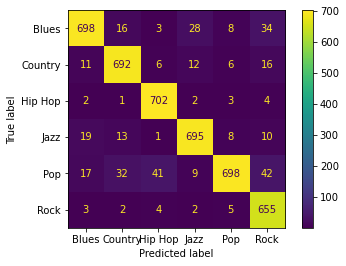

----------- Testing Set Report -----------
Accuracy 0.626
Precision 0.6250922527936705
Recall 0.6334102482346995
F1 0.6256787679292457
Confusion matrix [[173  31   0  17  15  23]
 [ 28 145  11  35  27  51]
 [  2   4 195   7  19  10]
 [ 12  16   0 166  11  12]
 [ 16  34  30  14 167  50]
 [ 19  14   7  13  33  93]]


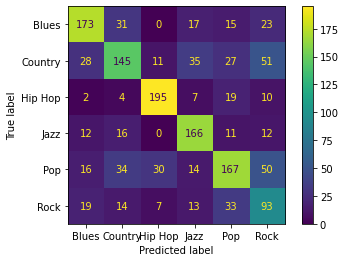

In [54]:
mnb_classified_train = gs_MNB.predict(X_train)
mnb_classified_test = gs_MNB.predict(X_test)
score_report(le.classes_, np.array(y_train), mnb_classified_train, np.array(y_test), mnb_classified_test)

# Complement Naive Bayes

In [27]:
GS_pipe_CNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', ComplementNB())
                       ])

sorted(GS_pipe_CNB.get_params().keys())

cnb_param_grid = dict(clf__alpha = [.01, .05, .1, .2, .4, 1])

gs_CNB = GridSearchCV(estimator=GS_pipe_CNB,
            param_grid=cnb_param_grid,
            scoring='accuracy',
            cv=3)

gs_CNB.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', ComplementNB())]),
             param_grid={'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.4, 1]},
             scoring='accuracy')

In [28]:
cnb_gs_testing_score = gs_CNB.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(cnb_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_CNB.best_params_))

Mean Testing Score: 59.07%
Best Parameter Combination Found During Grid Search: 
{'clf__alpha': 0.4}


----------- Training Set Report -----------
Accuracy 0.8853333333333333
Precision 0.885500922357269
Recall 0.8902874889725286
F1 0.8849522804405776
Confusion matrix [[688  43   5  28  21  54]
 [  7 629   5   7   9  19]
 [  7  10 724   2  39  17]
 [ 29  29   1 702  17  18]
 [ 17  42  20   7 638  50]
 [  2   3   2   2   4 603]]


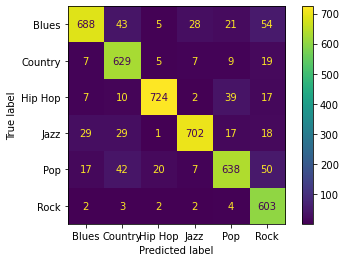

----------- Testing Set Report -----------
Accuracy 0.5906666666666667
Precision 0.5898620484184615
Recall 0.5753158952899737
F1 0.5698445463780064
Confusion matrix [[184  37   2  22  25  35]
 [ 14 114   4  19  23  48]
 [ 10  14 214   9  40  31]
 [ 21  27   3 183  24  27]
 [ 12  41  15  12 138  45]
 [  9  11   5   7  22  53]]


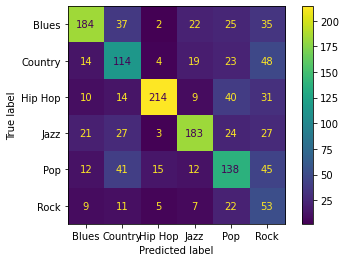

In [55]:
cnb_classified_train = gs_CNB.predict(X_train)
cnb_classified_test = gs_CNB.predict(X_test)
score_report(le.classes_, np.array(y_train), cnb_classified_train, np.array(y_test), cnb_classified_test)

# KNN Classifier

In [29]:
GS_pipe_KNN = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                        ('clf', KNeighborsClassifier())
                        ])

knn_param_grid = dict(clf__n_neighbors = [100, 150, 200],
                     clf__p = [1, 2])

gs_KNN = GridSearchCV(estimator=GS_pipe_KNN,
            param_grid=knn_param_grid,
            scoring='accuracy',
            cv=3)

gs_KNN.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': [100, 150, 200], 'clf__p': [1, 2]},
             scoring='accuracy')

In [30]:
knn_gs_testing_score = gs_KNN.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(knn_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_KNN.best_params_))

Mean Testing Score: 45.2%
Best Parameter Combination Found During Grid Search: 
{'clf__n_neighbors': 150, 'clf__p': 2}


----------- Training Set Report -----------
Accuracy 0.4797777777777778
Precision 0.4814582420937619
Recall 0.5456317909894387
F1 0.4481873897266276
Confusion matrix [[582 233  45 201 135 246]
 [ 35 235   7 107  38 102]
 [  9  20 561  14  47  35]
 [ 18  32   4 263  20  31]
 [100 232 134 156 479 308]
 [  6   4   6   7   9  39]]


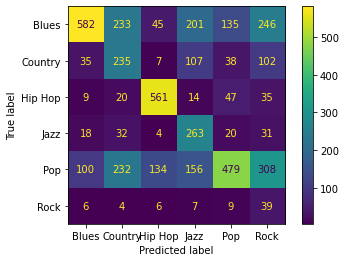

----------- Testing Set Report -----------
Accuracy 0.452
Precision 0.447068313146174
Recall 0.5122279348240688
F1 0.41890972810294863
Confusion matrix [[196  81  20  68  66  67]
 [ 11  50   4  35   8  37]
 [  1   6 167   4  12   9]
 [  4  17   3  87  18   6]
 [ 37  87  48  54 165 107]
 [  1   3   1   4   3  13]]


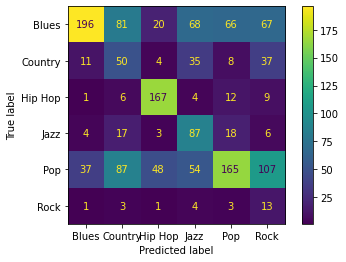

In [56]:
knn_classified_train = gs_KNN.predict(X_train)
knn_classified_test = gs_KNN.predict(X_test)
score_report(le.classes_, np.array(y_train), knn_classified_train, np.array(y_test), knn_classified_test)

# Neural Net

In [65]:
X = lemmed_lyrics
y = combined_genre_data.Genres

In [84]:
MAX_NB_WORDS = 25000
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(lemmed_lyrics)
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

Found 28831 unique tokens.


In [85]:
X = tokenizer.texts_to_sequences(lemmed_lyrics)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (6000, 150)


In [86]:
y = pd.get_dummies(combined_genre_data.Genres).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (6000, 6)


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4500, 150)
(1500, 150)
(4500, 6)
(1500, 6)


In [88]:
model = keras.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

epochs = 10
batch_size = 100

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 100)          2500000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 150, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 606       
Total params: 2,581,006
Trainable params: 2,581,006
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
41/41 [==============================] - 31s 707ms/step - loss: 1.7808 - accuracy: 0.1943 - val_loss: 1.5967 - val_accuracy: 0.3333
Epoch 2/10
41/41 [==============================] - 33s 796ms/step - loss: 1.5321 - accuracy: 

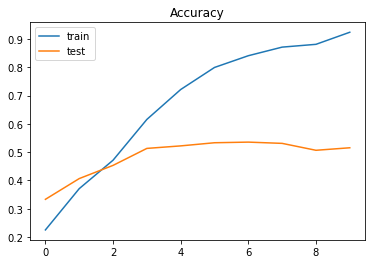

In [89]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [90]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

y_pred_classes_train = y_pred_train.argmax(axis=-1)
classified_train = le.inverse_transform(y_pred_classes_train)

y_train_classes = y_train.argmax(axis=-1)
gold_train = le.inverse_transform(y_train_classes)

y_pred_classes_test = y_pred_test.argmax(axis=-1)
classified_test = le.inverse_transform(y_pred_classes_test)

y_test_classes = y_test.argmax(axis=-1)
gold_test = le.inverse_transform(y_test_classes)

----------- Training Set Report -----------
Accuracy 0.9022222222222223
Precision 0.9023466103571102
Recall 0.903412471184084
F1 0.9019714191129371
Confusion matrix [[712  34   6   8  20  62]
 [ 12 661   3  25  18  28]
 [  2   2 732   2  28   7]
 [  5  14   5 683  10  13]
 [ 13  21  14   5 638  27]
 [ 11  14   3  11  17 634]]


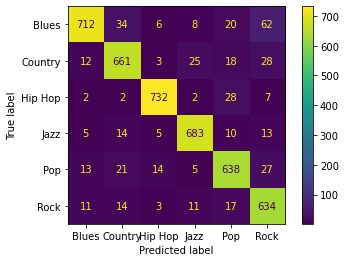

----------- Testing Set Report -----------
Accuracy 0.5313333333333333
Precision 0.5315692237378368
Recall 0.5297392166049795
F1 0.5273970402882646
Confusion matrix [[162  47   3  27  29  49]
 [ 27 102  10  45  41  48]
 [  3   6 192   1  28  12]
 [ 21  38   3 158   9  29]
 [  7  31  21   6 118  26]
 [ 25  30   8  29  44  65]]


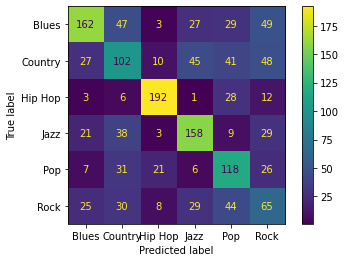

In [91]:
score_report(le.classes_, gold_train, classified_train, gold_test, classified_test)

# Results

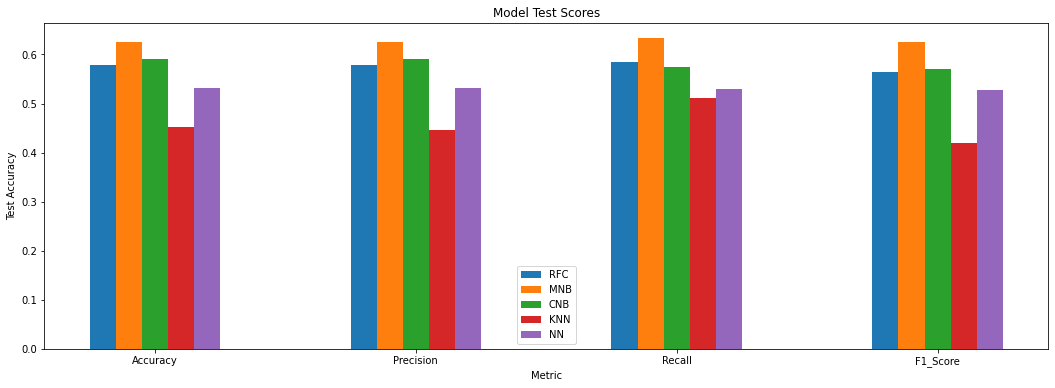

In [106]:
model_results = {'RFC': [.579, .578, .584, .565],
                'MNB': [.626, .625, .633, .626],
                'CNB': [.591, .590, .575, .570],
                'KNN': [.452, .447, .512, .419],
                'NN': [.531, .532, .530, .527]}

X = ['Accuracy', 'Precision', 'Recall', 'F1_Score']

RFC = model_results['RFC']
MNB = model_results['MNB']
CNB = model_results['CNB']
KNN = model_results['KNN']
NN = model_results['NN']

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, RFC, 0.1, label = 'RFC')
plt.bar(X_axis - 0.1, MNB, 0.1, label = 'MNB')
plt.bar(X_axis, CNB, 0.1, label = 'CNB')
plt.bar(X_axis + 0.1, KNN, 0.1, label = 'KNN')
plt.bar(X_axis + 0.2, NN, 0.1, label = 'NN')

plt.xticks(X_axis, X)

plt.gcf().set_size_inches(18, 6)
plt.xlabel("Metric")
plt.ylabel('Test Accuracy')
plt.title("Model Test Scores")
plt.legend()
plt.show()

# Word Cloud

In [70]:
combined_genre_data.drop("Unnamed: 0", axis=1)
dfs_split_by_genre = {label:combined_genre_data[combined_genre_data.Genres == label] for label in labels}
dfs_split_by_genre['Country'].Lyric
lyrics_split_by_genre = {label:clean_lyrics_lemma(list(dfs_split_by_genre[label].Lyric)) for label in labels}

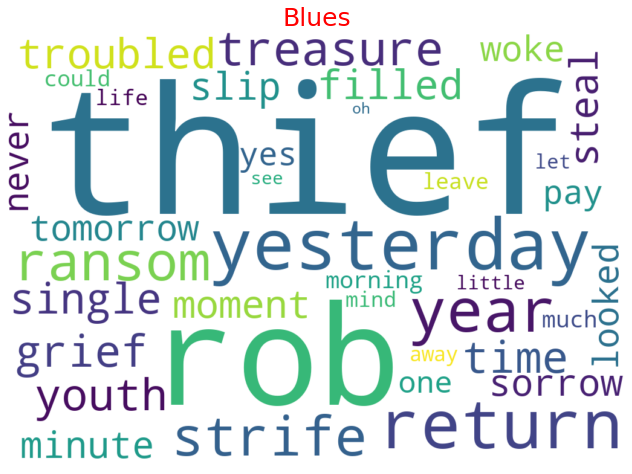

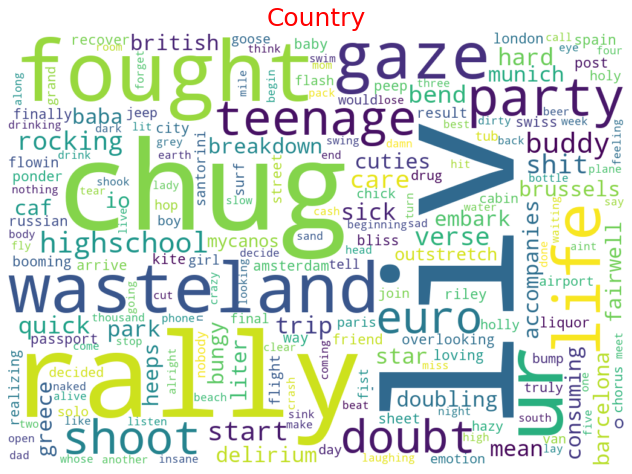

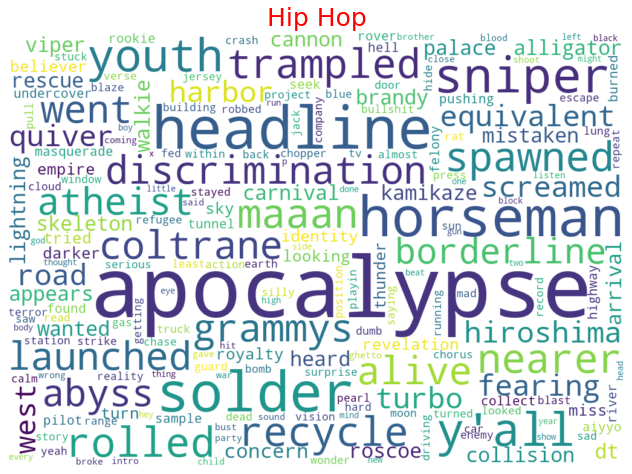

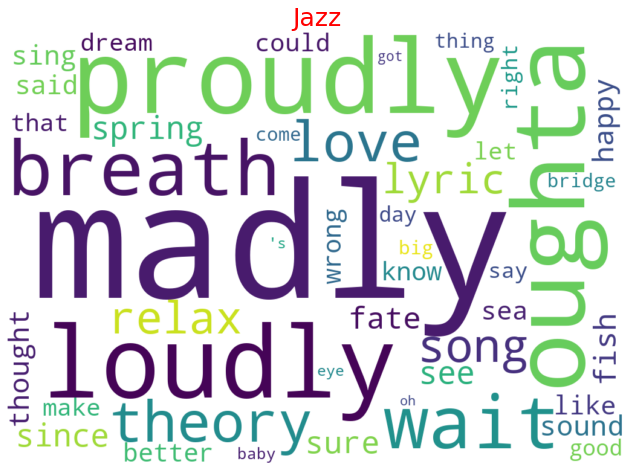

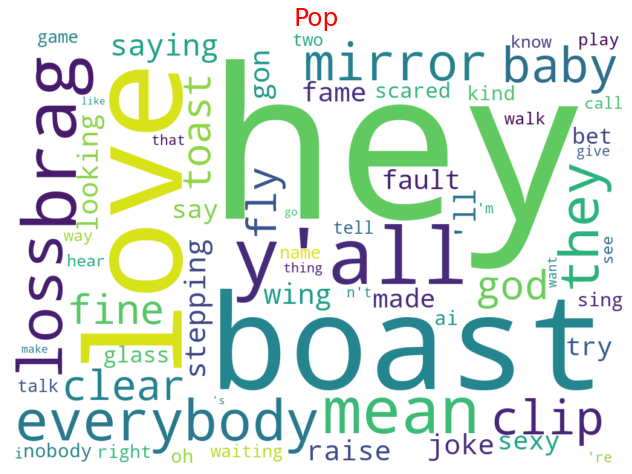

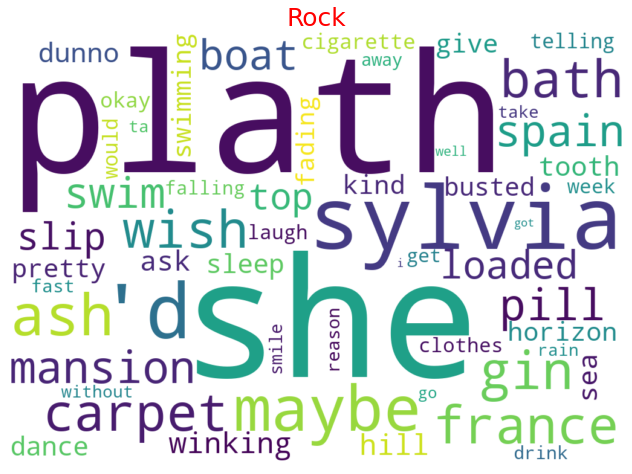

In [71]:
for key in lyrics_split_by_genre:
    lemmed_lyrics_tokenized = [nltk.word_tokenize(doc) for doc in lyrics_split_by_genre[key]]
    dictionary = gensim.corpora.Dictionary(lemmed_lyrics_tokenized)
    # dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in lemmed_lyrics_tokenized]
    
    tfidf = models.TfidfModel(bow_corpus)
    corpus_tfidf = tfidf[bow_corpus]

    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=15, id2word=dictionary, passes=2, workers=4)
    
    weights = tfidf[bow_corpus[0]]

    # Get terms from the dictionary and pair with weights

    weights = [(dictionary[pair[0]], pair[1]) for pair in weights]
    weights = sorted(weights, key = lambda x: x[1])[-200:]
    weights[-20:]
    
    # Initialize the word cloud

    d = {}
    for a, x in weights:
        d[a] = x

    wc = WordCloud(
        background_color="white",
        max_words=2000,
        width = 1024,
        height = 720,
        stopwords=stopwords.words("english")
    )

    wc.generate_from_frequencies(d)
    plt.figure(figsize = (12, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.title(f"{key}", color = "r", fontsize = 25)
    plt.axis("off")
    plt.show()